# AI-Powered Personal Finance & Savings Recommendation System

## Problem Statement
The goal of this project is to predict monthly savings and generate personalized financial recommendations using user income and spending behavior.

## Dataset Overview
We use a real-world Indian personal finance dataset containing income, expenses, demographics, and savings targets for 20,000 individuals.

## Tech Stack
- Python
- Pandas & NumPy
- Scikit-learn
- Matplotlib & Seaborn


## Data Loading

The dataset is loaded into a Pandas DataFrame. We verify data shape and column structure to ensure consistency.


In [1]:
import pandas as pd

# df = pd.read_csv("Indian_Personal_Finance_Dataset.csv")  # adjust name if needed
df = pd.read_csv('/content/drive/MyDrive/Datasets/Indian_Personal_Finance_Dataset.csv')

print(df.head())
print("\nShape:", df.shape)
print("\nColumns:\n", df.columns)

          Income  Age  Dependents     Occupation City_Tier          Rent  \
0   44637.249636   49           0  Self_Employed    Tier_1  13391.174891   
1   26858.596592   34           2        Retired    Tier_2   5371.719318   
2   50367.605084   35           1        Student    Tier_3   7555.140763   
3  101455.600247   21           0  Self_Employed    Tier_3  15218.340037   
4   24875.283548   52           4   Professional    Tier_2   4975.056710   

   Loan_Repayment    Insurance     Groceries    Transport  ...  \
0        0.000000  2206.490129   6658.768341  2636.970696  ...   
1        0.000000   869.522617   2818.444460  1543.018778  ...   
2     4612.103386  2201.800050   6313.222081  3221.396403  ...   
3     6809.441427  4889.418087  14690.149363  7106.130005  ...   
4     3112.609398   635.907170   3034.329665  1276.155163  ...   

   Desired_Savings  Disposable_Income  Potential_Savings_Groceries  \
0      6200.537192       11265.627707                  1685.696222   
1     

## Feature Selection and Target Variable

In this step, we select the relevant input features required for modeling and define the target variable.

- **Input features (`X`)** include income, demographic attributes, and various expense categories that influence saving behavior.
- **Target variable (`y`)** is `Desired_Savings`, which represents the amount a user aims to save monthly.

We also verify that there are no missing values in the selected features or the target variable to ensure data quality before model training.


In [3]:
feature_cols = [
    'Income', 'Age', 'Dependents', 'Occupation', 'City_Tier',
    'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport',
    'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare',
    'Education', 'Miscellaneous'
]

target_col = 'Desired_Savings'

X = df[feature_cols]
y = df[target_col]

print(X.isnull().sum())
print(y.isnull().sum())

Income            0
Age               0
Dependents        0
Occupation        0
City_Tier         0
Rent              0
Loan_Repayment    0
Insurance         0
Groceries         0
Transport         0
Eating_Out        0
Entertainment     0
Utilities         0
Healthcare        0
Education         0
Miscellaneous     0
dtype: int64
0


## Identifying Categorical and Numerical Features

Machine learning models require different preprocessing strategies for categorical and numerical data.

- **Categorical features** (such as occupation and city tier) represent qualitative information and will be encoded later.
- **Numerical features** (such as income and expenses) represent quantitative values and will be scaled for better model performance.

In this step, we automatically identify categorical and numerical columns based on their data types.


In [4]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['Occupation', 'City_Tier']
Numeric: ['Income', 'Age', 'Dependents', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous']


## Feature Engineering: Behavioral Financial Metrics

To improve model performance and better capture real-world financial behavior, we engineer additional features from raw expense data.

The following features are created:

- **Total_Expense**: Sum of all monthly expense categories.
- **Expense_Income_Ratio**: Proportion of income spent each month, indicating overall spending discipline.
- **Discretionary_Spend**: Sum of non-essential expenses such as eating out, entertainment, and miscellaneous costs.
- **Discretionary_Ratio**: Ratio of discretionary spending to income, capturing lifestyle-related spending behavior.
- **High_Dependents**: Binary indicator representing users with three or more dependents.
- **Is_Tier1_City**: Binary flag indicating whether the user lives in a Tier 1 city.

These engineered features help the model learn behavioral patterns beyond raw income and expense values.


In [5]:
X = df[feature_cols].copy()
X['Total_Expense'] = (
    X['Rent'] +
    X['Loan_Repayment'] +
    X['Insurance'] +
    X['Groceries'] +
    X['Transport'] +
    X['Eating_Out'] +
    X['Entertainment'] +
    X['Utilities'] +
    X['Healthcare'] +
    X['Education'] +
    X['Miscellaneous']
)

X['Expense_Income_Ratio'] = X['Total_Expense'] / X['Income']

X['Discretionary_Spend'] = (
    X['Eating_Out'] +
    X['Entertainment'] +
    X['Miscellaneous']
)

X['Discretionary_Ratio'] = X['Discretionary_Spend'] / X['Income']

X['High_Dependents'] = (X['Dependents'] >= 3).astype(int)

X['Is_Tier1_City'] = (X['City_Tier'] == 'Tier 1').astype(int)

print(X[['Total_Expense', 'Expense_Income_Ratio', 'Discretionary_Ratio', 'High_Dependents', 'Is_Tier1_City']].head())

   Total_Expense  Expense_Income_Ratio  Discretionary_Ratio  High_Dependents  \
0   33371.621929              0.747618             0.090048                0   
1   17181.777859              0.639712             0.084288                0   
2   36476.154459              0.724199             0.076746                0   
3   69837.646632              0.688357             0.102749                0   
4   18609.583016              0.748115             0.075116                1   

   Is_Tier1_City  
0              0  
1              0  
2              0  
3              0  
4              0  


## Importing Machine Learning Tools

In this section, we import the required modules from Scikit-learn to build and evaluate the machine learning model.

- **train_test_split** is used to divide the dataset into training and testing sets.
- **OneHotEncoder** converts categorical features into numerical format.
- **StandardScaler** normalizes numerical features to ensure balanced model learning.
- **ColumnTransformer** applies different preprocessing steps to numerical and categorical features.
- **Pipeline** combines preprocessing and modeling into a single, streamlined workflow.
- **RandomForestRegressor** is used as the predictive model due to its robustness and ability to capture non-linear relationships.
- **mean_absolute_error** and **r2_score** are used to evaluate model performance.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## Separating Categorical and Numerical Features

Before preprocessing, we separate the input features into **categorical** and **numerical** columns.

- **Categorical features** represent non-numeric labels (e.g., job type, city tier) and need encoding.
- **Numerical features** contain continuous or count-based values and may require scaling.

This separation allows us to apply appropriate preprocessing techniques to each type using a `ColumnTransformer`.


In [7]:
cat_cols = ['Occupation', 'City_Tier']
num_cols = [col for col in X.columns if col not in cat_cols]

## Splitting Data into Training and Testing Sets

To evaluate the performance of our machine learning model, we split the dataset into:

- **Training set (80%)** – used to train the model
- **Testing set (20%)** – used to evaluate how well the model generalizes to unseen data

A fixed `random_state` is used to ensure reproducibility of results.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Feature Preprocessing Using ColumnTransformer

Different types of features require different preprocessing techniques:

- **Numerical features** are scaled using `StandardScaler` to bring them to a similar range.
- **Categorical features** are converted into numerical form using `OneHotEncoder`.

`ColumnTransformer` allows us to apply these transformations **in parallel** to the appropriate columns, ensuring a clean and organized preprocessing pipeline.


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

## Building the Machine Learning Pipeline

In this step, we define the machine learning model and combine it with the preprocessing steps using a `Pipeline`.

- **RandomForestRegressor** is chosen because:
  - It handles non-linear relationships well
  - It is robust to outliers
  - It performs well without extensive hyperparameter tuning

- The `Pipeline` ensures that:
  - Preprocessing and model training happen in a single workflow
  - The same transformations are applied during training and testing
  - The process is clean, reproducible, and free from data leakage


In [10]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])


## Training the Model

In this step, we train the machine learning pipeline using the training dataset.

The pipeline automatically:
- Applies all preprocessing steps (scaling and encoding)
- Trains the Random Forest model on the processed data

Once trained, the model learns patterns between income, expenses, demographics, and desired savings.


In [11]:
print("Training model...")
pipeline.fit(X_train, y_train)
print("Training complete.")


Training model...
Training complete.


## Model Evaluation

After training the model, we evaluate its performance using the test dataset.

We use the following metrics:
- **Mean Absolute Error (MAE):** Measures the average absolute difference between predicted and actual savings.
- **R² Score:** Indicates how well the model explains the variance in the target variable.

These metrics help assess how accurately the model predicts desired savings on unseen data.


In [12]:
y_pred = pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 608.3297696708718
R2 Score: 0.9196067295476028


## Feature Importance Analysis

To understand how the model makes predictions, we analyze the importance of each feature used by the Random Forest model.

Feature importance helps us:
- Identify which factors influence savings the most
- Gain interpretability into the model’s decision-making
- Provide data-driven insights for financial recommendations

Since categorical features are one-hot encoded, we first extract their generated feature names before combining them with numerical features.


In [13]:
import pandas as pd
import numpy as np

# Extract feature names after preprocessing
ohe = pipeline.named_steps['preprocess'] \
              .named_transformers_['cat'] \
              .get_feature_names_out(cat_cols)

all_features = num_cols + list(ohe)

importances = pipeline.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp.head(10)

,Feature,Importance
0,Income,0.914020
15,Expense_Income_Ratio,0.046614
11,Healthcare,0.008314
10,Utilities,0.006579
7,Transport,0.005749
6,Groceries,0.002114
13,Miscellaneous,0.002000
5,Insurance,0.001770
9,Entertainment,0.001630
12,Education,0.001597


## Rule-Based Personalized Savings Recommendations

In addition to predicting savings, we generate **actionable financial recommendations** using simple rule-based logic.

These rules analyze an individual’s spending behavior and:
- Identify overspending patterns
- Suggest practical ways to reduce expenses
- Provide human-readable insights alongside model predictions

This hybrid approach combines **machine learning predictions** with **domain-driven financial rules**, making the system more useful and interpretable.


In [14]:
def generate_recommendation(row):
    tips = []

    if row['Discretionary_Ratio'] > 0.15:
        tips.append("Reduce eating out & entertainment expenses")

    if row['Rent'] / row['Income'] > 0.35:
        tips.append("Consider optimizing housing costs")

    if row['Groceries'] > 0.15 * row['Income']:
        tips.append("Plan grocery purchases more efficiently")

    if row['Expense_Income_Ratio'] > 0.75:
        tips.append("Overall spending is high compared to income")

    if not tips:
        tips.append("Your spending is well balanced. Keep it up!")

    return tips

## Generating Predictions and Personalized Recommendations for a User

To demonstrate the practical usage of the model, we test it on a sample user from the test dataset.

For this user:
- The trained pipeline predicts the **expected monthly savings**
- The rule-based system generates **personalized financial recommendations**

This simulates how the system could be integrated into a real-world financial application.


In [19]:
sample_user = X_test.iloc[668]

predicted_savings = pipeline.predict(sample_user.to_frame().T)[0]
recommendations = generate_recommendation(sample_user)

print("Predicted Monthly Savings:", round(predicted_savings, 2))
print("Recommendations:")
for r in recommendations:
    print("-", r)

Predicted Monthly Savings: 6421.9
Recommendations:
- Your spending is well balanced. Keep it up!


## Conclusion

This project demonstrates an AI-powered personal finance system that:

- Predicts a user’s potential monthly savings based on income, expenses, and demographics.
- Generates personalized, actionable financial recommendations using a hybrid of machine learning and rule-based logic.
- Leverages feature engineering, preprocessing pipelines, and Random Forest regression for robust predictions.
- Provides insights into key spending behaviors influencing savings, enhancing interpretability.

**Future Work:**
- Build a web-based dashboard using Streamlit or Flask to make it interactive.
- Integrate real-time data from user accounts to provide live recommendations.
- Incorporate clustering to segment users and provide tailored financial advice.
- Expand recommendation rules using more advanced financial planning techniques.


In [20]:
from joblib import dump

# Save the full pipeline
dump(pipeline, 'personal_finance_pipeline.joblib')


['personal_finance_pipeline.joblib']

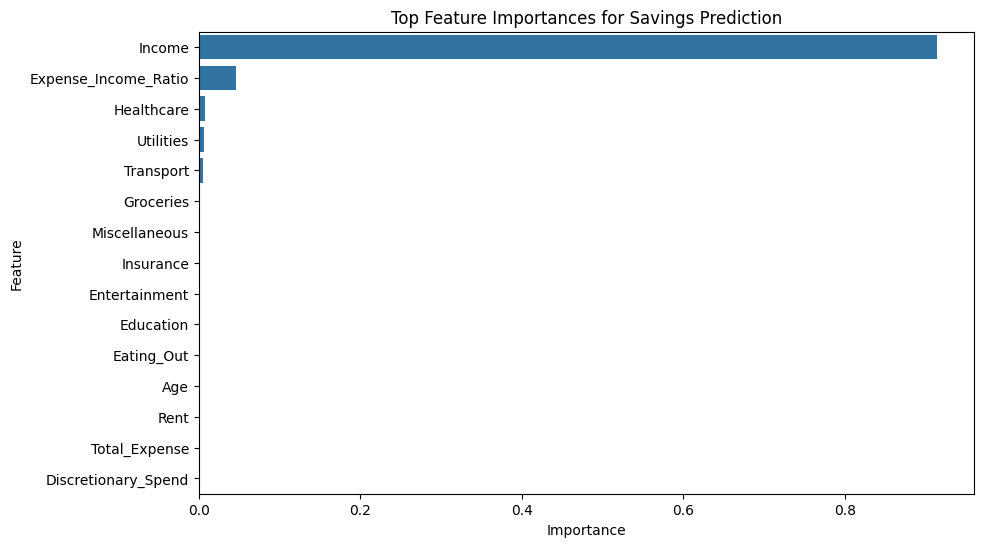

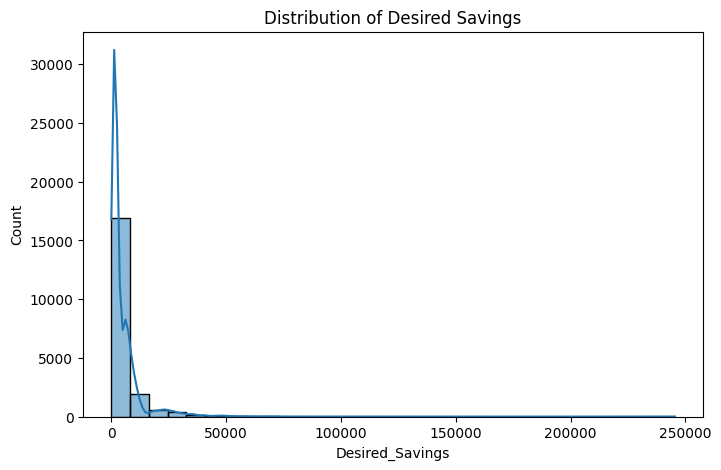

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15))
plt.title("Top Feature Importances for Savings Prediction")
plt.show()

# Savings distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Desired_Savings'], bins=30, kde=True)
plt.title("Distribution of Desired Savings")
plt.show()
